<a href="https://colab.research.google.com/github/willhenrich/gun_detector/blob/main/Henrich_Gun_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Nerf Gun in Boston

Last week, a school in Boston went into lockdown because of a report of a student with a gun. Police found that [it was in fact a Nerf toy gun](https://www.nbcboston.com/news/local/nerf-gun-prompts-police-response-to-boston-latin-academy/3245333/). Had it been caught on camera by ZeroEyes, this might have been prevented. To this end, I've created a simple gun detector model, which accurately classifies images of real guns vs. toy guns and hands that aren't holding guns at all. It achieves perfect recall and precision on a 54-image validation set with less than ten epochs of training.

### The Model

The code below shows how I created the model using the the fast.ai library. I created a dataset of 272 images from DuckDuckGo search and cleaned them manually. Then I used the dataset to fine-tune several image classification models. Throughout, I use ideas and code from the [fast.ai course](https://course.fast.ai/) and feedback from ChatGPT. <br><br>

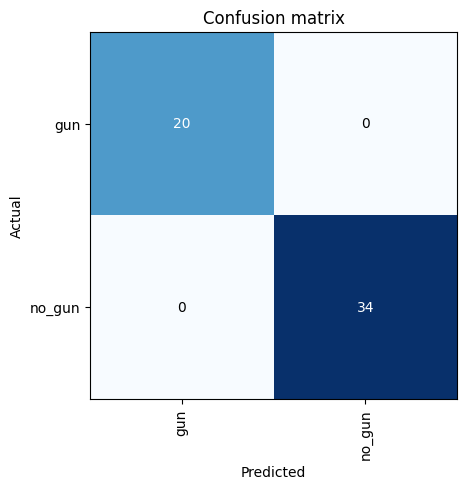

In [ ]:
!pip install -Uqq fastai duckduckgo_search

In [46]:
import os
import shutil

from pathlib import Path
from PIL import Image
from IPython.display import display
from typing import List, Optional, Tuple

from google.colab import drive, files
from duckduckgo_search import DDGS
from fastdownload import download_url

from fastai.vision.all import *
from fastai.vision.widgets import *

# Getting the Data

Because this model is for demonstration purposes, it doesn't use real-world data. Instead, I downloaded a few hundred images—mostly stock photos—of hands holding real guns, hands holding toy guns, and empty hands. Each category has its own subdirectory.

In [99]:
# Functions to get the data:


def image_search(term: str, max: int) -> list:
    """Returns a list of image URLs."""
    with DDGS() as ddgs:
        results = ddgs.images(term, max_results=max)
        results_list = L(dictionary["image"] for dictionary in results)
    return results_list


def create_directory(subdir_name: str, parent: Optional[Path]=Path(".")) -> Path:
    """Creates a directory and returns its path."""
    subdir_path = parent / subdir_name
    subdir_path.mkdir(exist_ok=True)
    return subdir_path


def download_images(term: str, max: int, dest: Path) -> None:
    """Downloads images in a list of URLs."""
    images = image_search(term, max)
    for url in images:
        try:
            download_url(url, dest)
        except Exception:
            pass


def clean(path: Path) -> int:
    """Removes broken image files and returns the number left."""
    failed = verify_images(get_image_files(path))
    failed.map(Path.unlink)
    return len(list(path.iterdir()))


def show_images(path: Path, n: int) -> None:
    """Displays n photos in path."""
    images = list(path.iterdir())
    print(f"{n} of {len(images)} images in \"{path}\":")
    for image in images[:n]:
        with Image.open(image) as img:
            display(img)
            print(f"{image.name}\n")


def get_gun_images(max_images: int) -> Tuple[str, Tuple[Path, ...]]:
    """Searches for, downloads, cleans, and resizes
    images of hands with and without real and toy guns.
    Returns the directories' paths.
    """
    # Create directories for each category:
    parent = create_directory("hand")
    gun = create_directory(parent/"gun")
    nogun = create_directory(parent/"nogun")

    # Download images:
    download_images("gun in hand", max_images, gun)

    other_terms = ["hand holding something", "hand holding toy gun", "hand holding water gun"]
    for term in other_terms:
        download_images(term, max_images // 3, nogun)

    # Clean, resize, and count images:
    gun_count = clean(gun)
    nogun_count = clean(nogun)

    print(f"\n{gun_count} images with guns and {nogun_count} images without.")

    return parent, gun, nogun

In [ ]:
# Download the images:

parent, gun, nogun = get_gun_images(max_images=150)

# Cleaning the Data

A single mislabeled gun image could weaken the classifier, so I hand-cleaned the images. Training a quick preliminary classifier makes this easier, though I went on to review all the images by hand. To keep things simple, I removed images of guns that looked ambiguously real.

In [87]:
# Functions to fine-tune a model and clean the data:


def define_block(parent: Path, image_size: int=256, batch_size: int=32) -> DataLoaders:
    """Defines a data block to fine-tune an image classification model.

    Args:
        image_size (int): The image width to resize to.
        parent (Path): The directory that contains subdirectories of images.
        batch_size (int): The number of images to include in a training batch.

    Returns:
        DataLoaders: A fast.ai DataLoaders object.
    """
    dls = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=valid, seed=42),
        get_y=parent_label,
        item_tfms=[Resize(image_size, method="squish")],
    ).dataloaders(parent, bs=batch_size)

    return dls


def tune(dls: DataLoaders, model, epochs: int, metrics) -> Learner:
    """Fine-tunes a model and returns a fast.ai Learner object.

    Args:
        dls (DataLoaders): A fast.ai DataLoaders object that describes the data.
        model: A pretrained vision model.
        epochs (int): The number of epochs to train. Defaults to 5.
        metrics: The metrics to print. Takes various types.

    Returns:
        Learner: A fast.ai Learner object.
    """
    learn = vision_learner(dls, model, metrics=metrics)
    learn.fine_tune(epochs)

    return learn


def clean_up(cleaner: ImageClassifierCleaner) -> None:
    """Writes the changes made in the cleaner widget.
    Must be ran after choosing images to clean in each category and dataset.
    """
    for idx in cleaner.delete():
        cleaner.fns[idx].unlink()
    for idx, cat in cleaner.change():
        shutil.move(str(cleaner.fns[idx]), parent / cat)

In [89]:
# Define hyperparameters, fine-tune a simple model, and clean the data:

image_size: int = 256
batch_size: int = 64
model = resnet18
epochs: int = 10
metrics = error_rate

# Define a fast.ai DataLoaders object:

dls_clean = define_block(parent, image_size, batch_size)

# Fine-tune a model:

learn_clean = tune(dls_clean, model, epochs, metrics)

# Create and open the cleaner widget:

cleaner = ImageClassifierCleaner(learn_clean, max_n=50)
cleaner

# Run cleanup() after choosing images to clean in each category and dataset.

epoch,train_loss,valid_loss,error_rate,time
0,1.460881,1.767542,0.305556,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.659240,1.099226,0.222222,00:05
1,0.516748,0.682933,0.138889,00:05
2,0.405284,0.439030,0.083333,00:06
3,0.308837,0.304659,0.083333,00:06
4,0.245515,0.243655,0.083333,00:05
5,0.204158,0.213633,0.111111,00:05
6,0.172420,0.195181,0.083333,00:05
7,0.149967,0.186498,0.083333,00:05
8,0.131909,0.184311,0.083333,00:05
9,0.117058,0.179017,0.083333,00:06


In [30]:
clean_up(cleaner) # Run after choosing images to clean in each category and dataset.

### Clean Dataset

For consistency, I used a [clean dataset](https://github.com/willhenrich/gun_detector/tree/main) of 272 images based on the section above.

In [63]:
# Upload cleaned data to Colab from https://github.com/willhenrich/gun_detector/tree/main:

drive.mount('/content/drive')
uploaded = files.upload()
shutil.unpack_archive("hands (1).zip", "hands_data")
clean_parent = Path("hands_data/hands")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving hands.zip to hands (1).zip


# Fine-Tuning a Model

Using the functions defined in [Cleaning the data](#cleaning-the-data), I fine-tuned and compared three ResNet models. Notably, ResNet50 achieved perfect recall and precision on the validation set in less than ten epochs, using standard hyperparameters. Resnet34 and Resnet18 also performed fairly well.

In [ ]:
# Define hyperparameters:

image_size: int = 256
batch_size: int = 32
epochs: int = 15
metrics = [Recall(), Precision()]

### ResNet50

ResNet50 achieved perfect recall and precision on the validation set in less than ten epochs.

In [84]:
model = resnet50
dls_resnet50 = define_block(image_size, clean_parent, batch_size)
learn_resnet50 = tune(dls_resnet50, model, epochs, metrics)

epoch,train_loss,valid_loss,recall_score,precision_score,time
0,0.936829,0.196416,0.941176,1.000000,00:06


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,recall_score,precision_score,time
0,0.170838,0.173642,0.941176,1.000000,00:06
1,0.132316,0.132989,0.970588,1.000000,00:06
2,0.095467,0.105337,0.970588,1.000000,00:06
3,0.086010,0.080648,0.970588,1.000000,00:06
4,0.074276,0.138382,0.970588,0.970588,00:06
5,0.058146,0.180779,0.970588,0.970588,00:05
6,0.059601,0.101605,0.970588,0.970588,00:06
7,0.054156,0.005299,1.000000,1.000000,00:06
8,0.045202,0.001447,1.000000,1.000000,00:05
9,0.040347,0.000485,1.000000,1.000000,00:06


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

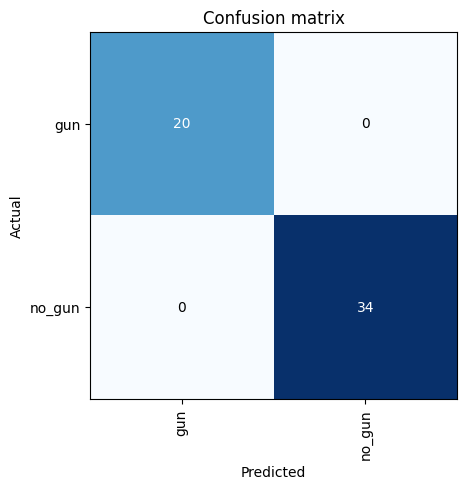

In [86]:
interp = ClassificationInterpretation.from_learner(learn_resnet34)
interp.plot_confusion_matrix()

### ResNet18

ResNet18 classified every validation image correctly except for a hoze nozzle.

In [77]:
model = resnet18
dls_resnet18 = define_block(image_size, clean_parent, batch_size)
learn_resnet18 = tune(dls_resnet18, model, epochs, metrics)

epoch,train_loss,valid_loss,recall_score,precision_score,time
0,0.877476,1.983461,0.058824,1.000000,00:06


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,recall_score,precision_score,time
0,0.281370,0.376281,0.735294,1.000000,00:05
1,0.181922,0.172210,0.941176,1.000000,00:06
2,0.137397,0.147077,0.970588,1.000000,00:06
3,0.108886,0.148844,0.941176,1.000000,00:05
4,0.083639,0.139423,0.970588,1.000000,00:06
5,0.067710,0.125205,0.970588,1.000000,00:05
6,0.055328,0.109950,0.970588,1.000000,00:06
7,0.045377,0.102011,0.970588,1.000000,00:06
8,0.039073,0.091210,0.970588,1.000000,00:05
9,0.032986,0.102969,0.970588,1.000000,00:05


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


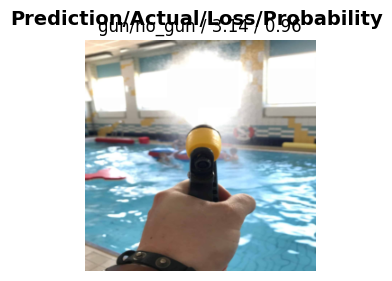

In [92]:
interp = ClassificationInterpretation.from_learner(learn_resnet18)
interp.plot_top_losses(1, nrows=1)

### ResNet34

ResNet34 achieved perfect recall and precision on the validation set in less than twenty epochs.

In [82]:
model = resnet34
dls_resnet34 = define_block(image_size, clean_parent, batch_size)
learn_resnet34 = tune(dls_resnet34, model, epochs, metrics)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s]


epoch,train_loss,valid_loss,recall_score,precision_score,time
0,0.842323,0.408938,0.764706,1.000000,00:06


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,recall_score,precision_score,time
0,0.173857,0.151218,0.941176,1.000000,00:06
1,0.155362,0.146444,0.970588,1.000000,00:05
2,0.135793,0.104823,0.970588,1.000000,00:05
3,0.100508,0.076465,0.970588,1.000000,00:06
4,0.090620,0.069265,0.970588,1.000000,00:06
5,0.073368,0.033016,0.970588,1.000000,00:06
6,0.059499,0.009954,1.000000,1.000000,00:06
7,0.049290,0.001983,1.000000,1.000000,00:06
8,0.043262,0.035566,1.000000,0.971429,00:06
9,0.037018,0.045638,1.000000,0.971429,00:06


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh